### Iris 품종 분류 예측 (다중 분류)
- 데이터셋: iris.csv
- 피쳐: 4개 Sepal Length, Sepal Width, Petal Length, Petal  Width
- 타겟: 1개 (Setosa Versicolor Verginica)
- 학습방법: 지도학습 >> 분류 >> 다중 분류
- 알고리즘: DNN (심층신경망)
- 프레임워크: pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimi

from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# 데이터 전처리용 모듈
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

# DF 로드 및 시각화 모듈
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 모듈 버전 확인
def ver_check():
    print(f'torch v.{torch.__version__}')
    print(f'pandas v.{pd.__version__}')

In [3]:
ver_check()

torch v.2.4.1
pandas v.2.0.3


In [4]:
# 데이터 로딩
DATA_FILE = DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3,4])
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


In [5]:
# 품종 칼럼 인코딩
# setosa:0 versi:1 virgi:2
label_data = irisDF['variety'].unique().tolist()
labels = dict(zip(label_data, range(len(label_data))))
print(labels)

irisDF['variety_encd'] = irisDF['variety'].replace(labels)
irisDF['variety_encd'].unique()

{'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


array([0, 1, 2], dtype=int64)

##### 피쳐&타겟 && trian/valid/test

In [6]:
targetDF = irisDF[['variety_encd']]
featureDF = irisDF[irisDF.columns[:-2]]

print(f'featureDF: {featureDF.shape} {featureDF.ndim}D')
print(f'targetDF: {targetDF.shape} {targetDF.ndim}D')

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, 
                                                    stratify=targetDF,
                                                    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=10)

print()
print(f'X_trian: {X_train.shape} {X_train.ndim}D')
print(f'y_trian: {y_train.shape} {y_train.ndim}D')
print(f'X_val: {X_val.shape} {X_val.ndim}D')
print(f'y_val: {y_val.shape} {y_val.ndim}D')
print(f'X_test: {X_test.shape} {X_test.ndim}D')
print(f'y_test: {y_test.shape} {y_test.ndim}D')

featureDF: (150, 4) 2D
targetDF: (150, 1) 2D

X_trian: (84, 4) 2D
y_trian: (84, 1) 2D
X_val: (28, 4) 2D
y_val: (28, 1) 2D
X_test: (38, 4) 2D
y_test: (38, 1) 2D


#### 모델 클래스 설계 및 정의
- 클래스 목적: iris 데이터 학습 및 품종 추론
- 클래스 이름: IrisMCFModel
- 부모 클래스: nn.Module
- 매개 	변수: layer별 입출력 개수 고정 -> 필요 X
- 기능_역할: init(): 모델 구조, forward(): 순방향 학습
- 클래스 구조
	* 입력층:	입력 4		출력 10		AF ReLU
	* 은닉층:	입력 10		출력 20		AF ReLU
	* 은닉층:	입력 20		출력 5 		AF ReLU
	* 출력층:	입력 5		출력 3		AF X


In [7]:
class IrisMCFModel(nn.Module):
    
	def __init__(self):
		super().__init__()

		self.in_layer = nn.Linear(4, 10)
		self.hd_layers = nn.ModuleList( [nn.Linear(10,20), nn.Linear(20,10)])
		self.out_layer = nn.Linear(10,3)

	def forward(self, x):

		y = F.relu( self.in_layer(x))

		for linear in self.hd_layers:
			y = F.relu( linear(y) )

		return self.out_layer(y)
	
	# 다중분류 => 손실함수 crossEntropyLoss가 내부에서 softmax 진행
	# out_layer 결과에 AF 처리 필요 X

In [8]:
## [테스트] 사용자 정의 모델 확인
model = IrisMCFModel()

print(model)
print()
summary(model, input_size=(150,4))

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
  )
  (out_layer): Linear(in_features=10, out_features=3, bias=True)
)



Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [150, 3]                  --
├─Linear: 1-1                            [150, 10]                 50
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-1                       [150, 20]                 220
│    └─Linear: 2-2                       [150, 10]                 210
├─Linear: 1-3                            [150, 3]                  33
Total params: 513
Trainable params: 513
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06

#### 데이터셋 클래스 설계 및 정의
- 데이터셋: iris.csv
- 피쳐_개수: 4개
- 타겟_개수: 3개 (품종 3개)
- 클래스이름: IrisDataset
- 부모클래스: utils.data.Dataset
- 속성_필드: featureDF, targetDF, n_rows, n_features
- 필수메서드:
	* init(self)
	* len(self)
	* getitem(self, idx)

In [9]:
class IrisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):

		self.featureDF = featureDF
		self.targetDF = targetDF
		self.n_rows = featureDF.shape[0]
		self.n_features = featureDF.shape[1]

	def __len__(self):
		return self.n_rows
	
	def __getitem__(self, idx):
		featureTS = torch.FloatTensor(self.featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor(self.targetDF.iloc[idx].values)

		return featureTS, targetTS
	


In [10]:
# [테스트] 
# 데이터셋 인스턴스 생성
irisDS = IrisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS)

for data, label in irisDL:
    print(data.shape, label.shape)
    break

torch.Size([1, 4]) torch.Size([1, 1])


#### 학습준비

In [11]:
EPOCH = 100
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

In [12]:
# trainDS, testDS, validDS
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

In [13]:
# 최적화 인스턴스
optimizer = optimi.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스
crossLoss = nn.CrossEntropyLoss()

# 성능지표 인스턴스
scoreFunc = MulticlassF1Score(num_classes=3)

#### 학습 진행

In [15]:
LOSS_history = {'train':[], 'val':[]}
SCORE_history = {'train':[], 'val':[]}

for ep in range(EPOCH):
    
	# 모델 학습 모드 전환
	model.train()

	loss_tot = 0
	score_tot = 0

	for featureTS, targetTS in trainDL:

		pre_y = model(featureTS)

		# print(pre_y[0])
		# print(targetTS[0])
		# break
		print("pre_y\n", pre_y, pre_y.shape)
		print("targetTS\n", targetTS, targetTS.shape)
		print("targetTS.reshape(-1)\n", targetTS.reshape(-1).shape)
		
		loss = crossLoss(pre_y, targetTS.reshape(-1).long())
		loss_tot += loss.item()

		score = scoreFunc(pre_y, targetTS.reshape(-1))
		score_tot += score.item()

		# weight, bias 업데이트
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	# 한 에포크 모델 학습 검증
	
	# 모델 검증 모드 전환
	model.eval()

	with torch.no_grad():

		val_featTS = torch.FloatTensor(valDS.featureDF.values)
		val_targTS = torch.FloatTensor(valDS.targetDF.values)
		
		pre_y_val = model(val_featTS)

		loss_val = crossLoss(pre_y_val, val_targTS.reshape(-1).long())
		score_val = scoreFunc(pre_y_val, val_targTS.reshape(-1))


	# 한 에포크 당 손실값과 성능평가값 저장
	LOSS_history['train'].append(loss_tot/len(trainDL))
	SCORE_history['train'].append(score_tot/len(trainDL))

	LOSS_history['val'].append(loss_val)
	SCORE_history['val'].append(score_val)

	if ep%20 == 0:
		print(f"[{ep}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['train'][-1]:.5f} Score: {SCORE_history['train'][-1]:.5f}")
		print(f"- [Valid] LOSS: {LOSS_history['val'][-1]:.5f} Score: {LOSS_history['val'][-1]:.5f}")


pre_y
 tensor([[ -9.7445,   0.1381,   5.2358],
        [  8.0135,   2.0507, -13.6432],
        [ -7.9523,   0.2771,   4.0263],
        [  9.6429,   2.0445, -15.4618],
        [ -8.7603,   0.1032,   4.7290],
        [ -3.3851,   2.3002,  -1.7421],
        [ -9.7762,   0.1429,   5.2468],
        [  6.6817,   1.7599, -11.4544],
        [ -6.0034,   1.0480,   1.7068],
        [  8.4843,   1.9327, -13.8712]], grad_fn=<AddmmBackward0>) torch.Size([10, 3])
targetTS
 tensor([[2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.]]) torch.Size([10, 1])
targetTS.reshape(-1)
 torch.Size([10])
pre_y
 tensor([[ -5.2071,   2.0071,  -0.2451],
        [  9.3239,   2.0376, -15.0484],
        [ -4.3876,   2.3903,  -1.3110],
        [ -8.0307,   0.4299,   3.8336],
        [ -7.7247,   0.1154,   4.1291],
        [  9.2090,   2.0994, -15.0686],
        [ -7.5285,   0.1219,   4.0056],
        [ -7.7407,   0.4211,   3.6807],
        [

#### 모델 학습 검증 시각화

Text(0.5, 1.0, 'MULTI Classifi SCORE')

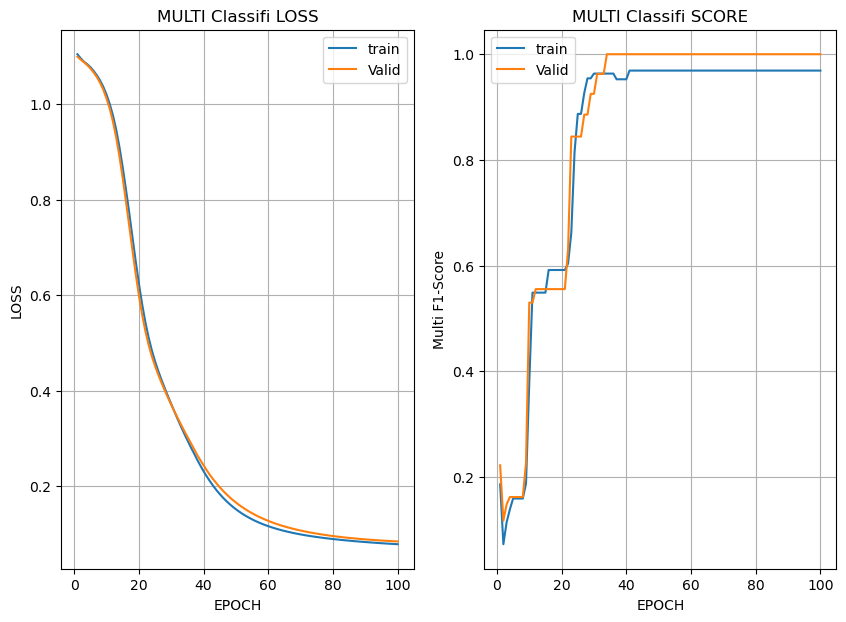

In [20]:
fig, axes = plt.subplots(1,2, figsize=(10,7))

axes[0].plot(range(1,EPOCH+1), LOSS_history['train'], label='train')
axes[0].plot(range(1,EPOCH+1), LOSS_history['val'], label='Valid')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('LOSS')
axes[0].set_title('MULTI Classifi LOSS')

axes[1].plot(range(1,EPOCH+1), SCORE_history['train'], label='train')
axes[1].plot(range(1,EPOCH+1), SCORE_history['val'], label='Valid')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('Multi F1-Score')
axes[1].set_title('MULTI Classifi SCORE')

##### 테스트 DS

In [22]:
test_featTS = torch.FloatTensor(testDS.featureDF.values)
test_targTS = torch.FloatTensor(testDS.targetDF.values)

pre_test = model(test_featTS)

print(f"test_loss: {crossLoss(pre_test, test_targTS.reshape(-1).long())}")
print(f"test_score: {scoreFunc(pre_test, test_targTS.reshape(-1))}")

test_loss: 0.0559559129178524
test_score: 1.0
